In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [48]:
df= pd.read_csv("Track Acceleration Data.csv")           # columns: time, ax, ay, az, angle?, tipping_flag?

#print(df.head())
df = df.dropna()
print(df.shape)
df.head()
df.columns.tolist

t = df['Time (sec)'].values
a = df['Acceleration5 (mm/sec**2)'].values

#print(t)
#print(a)

(90, 2)


In [51]:
df = pd.read_csv("Track Acceleration Data.csv")            # columns: time, ax, ay, az, angle?, tipping_flag?

#print(df.head())
df = df.dropna()
print(df.size)


a_s = pd.Series(a).rolling(21, center=True, min_periods=1).mean().values
jerk = np.gradient(a_s, t)

# Example thresholds: tune to your file
jmax = np.percentile(np.abs(jerk), 95)  # near-top jerk that didn’t tip in the data
amax = np.percentile(np.abs(a_s), 95)     # near-top accel that didn’t tip

print("Candidate accel limit:", amax)
print("Candidate jerk limit:", jmax)

# Optional: mark “unsafe” windows from a tipping_flag or angle threshold
if 'tipping_flag' in df.columns:
    unsafe = df['tipping_flag'].astype(bool)
    print("Unsafe fraction:", unsafe.mean())

180
Candidate accel limit: 755.5472440226179
Candidate jerk limit: 231.63422382100816


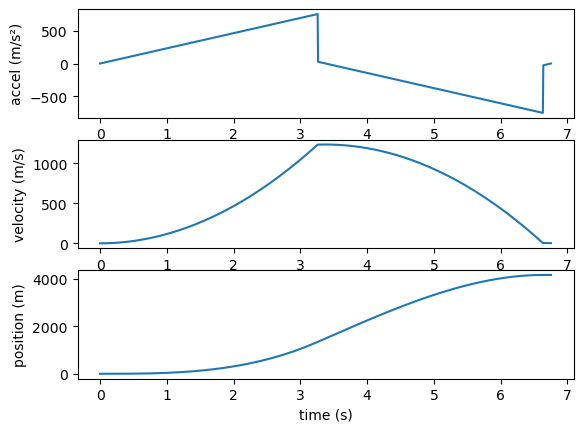

In [56]:
# Compute S-curve time constants
distance = 10
t_ramp = amax / jmax
# Estimate total profile duration (simplified)
t_total = 2 * (t_ramp + np.sqrt(distance / amax))

t = np.linspace(0, t_total, 1000)
a = np.zeros_like(t)
v = np.zeros_like(t)
x = np.zeros_like(t)

for i in range(1, len(t)):
    dt = t[i] - t[i-1]
    # simple symmetric jerk-limited acceleration pattern
    if t[i] < t_ramp:
        a[i] = jmax * t[i]
    elif t[i] < (t_total/2 - t_ramp):
        a[i] = amax
    elif t[i] < (t_total/2 + t_ramp):
        a[i] = amax - jmax * (t[i] - (t_total/2 - t_ramp))
    elif t[i] < (t_total - t_ramp):
        a[i] = -amax
    else:
        a[i] = -amax + jmax * (t[i] - (t_total - t_ramp))
    v[i] = v[i-1] + a[i]*dt
    x[i] = x[i-1] + v[i]*dt

plt.subplot(3,1,1); plt.plot(t,a); plt.ylabel("accel (m/s²)")
plt.subplot(3,1,2); plt.plot(t,v); plt.ylabel("velocity (m/s)")
plt.subplot(3,1,3); plt.plot(t,x); plt.ylabel("position (m)"); plt.xlabel("time (s)")
plt.show()